## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

# Sklearn Core
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

plt.style.use('ggplot')
SEED = 42

C:\Users\filbe\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Prepare Data

In [21]:
def load_and_prep_data(filepath):
    """
    Loads data and creates the classification target based on Exam_Score.
    """
    df = pd.read_csv(filepath)
    
    # Drop duplicates if any
    df = df.drop_duplicates()
    
    # CLASSIFICATION LOGIC:
    # We map the continuous Exam_Score to 3 classes:
    # 0: Low Performance (< 65)
    # 1: Average Performance (65 - 79)
    # 2: High Performance (>= 80)
    def categorize_score(score):
        if score >= 85:
            return "Distinction"
        elif score >= 75:
            return "B+"
        elif score >= 70:
            return "B"
        elif score >= 65:
            return "B-"
        elif score >= 55:
            return "Pass"
        else:
            return "Fail"

    # Create Target
    df['Performance_Category'] = df['Exam_Score'].apply(categorize_score)
    
    # Drop the original continuous target to prevent data leakage
    df = df.drop(columns=['Exam_Score'])
    
    return df

# Execution
df = load_and_prep_data('StudentPerformanceFactors.csv')
print(f"Data Loaded. Shape: {df.shape}")
print(f"Class Distribution:\n{df['Performance_Category'].value_counts(normalize=True)}")

Data Loaded. Shape: (6607, 20)
Class Distribution:
Performance_Category
B-             0.534282
B              0.227183
Pass           0.219767
B+             0.013471
Distinction    0.005297
Name: proportion, dtype: float64


In [3]:
df

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Performance_Category
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,Good
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,Pass
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,Good
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,Good
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,Good
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,Good
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,Good
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,Good


## Exploratory Data Analysis


--- Numerical Summary ---
       Hours_Studied   Attendance  Sleep_Hours  Previous_Scores  \
count    6607.000000  6607.000000   6607.00000      6607.000000   
mean       19.975329    79.977448      7.02906        75.070531   
std         5.990594    11.547475      1.46812        14.399784   
min         1.000000    60.000000      4.00000        50.000000   
25%        16.000000    70.000000      6.00000        63.000000   
50%        20.000000    80.000000      7.00000        75.000000   
75%        24.000000    90.000000      8.00000        88.000000   
max        44.000000   100.000000     10.00000       100.000000   

       Tutoring_Sessions  Physical_Activity  
count        6607.000000        6607.000000  
mean            1.493719           2.967610  
std             1.230570           1.031231  
min             0.000000           0.000000  
25%             1.000000           2.000000  
50%             1.000000           3.000000  
75%             2.000000           4.000000  
m

C:\Users\filbe\AppData\Local\Temp\ipykernel_26500\1212373785.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Performance_Category', data=df, palette='viridis', order=["Distinction", "Good", "Pass", "Fail"])


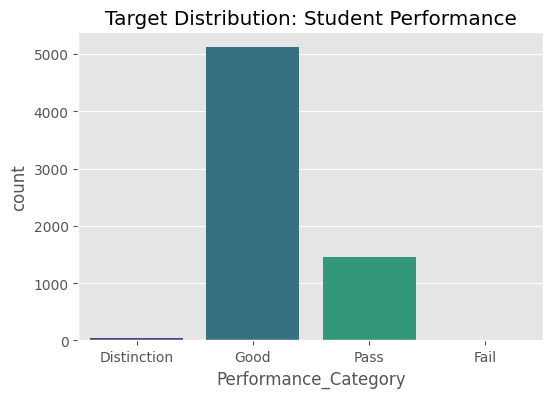

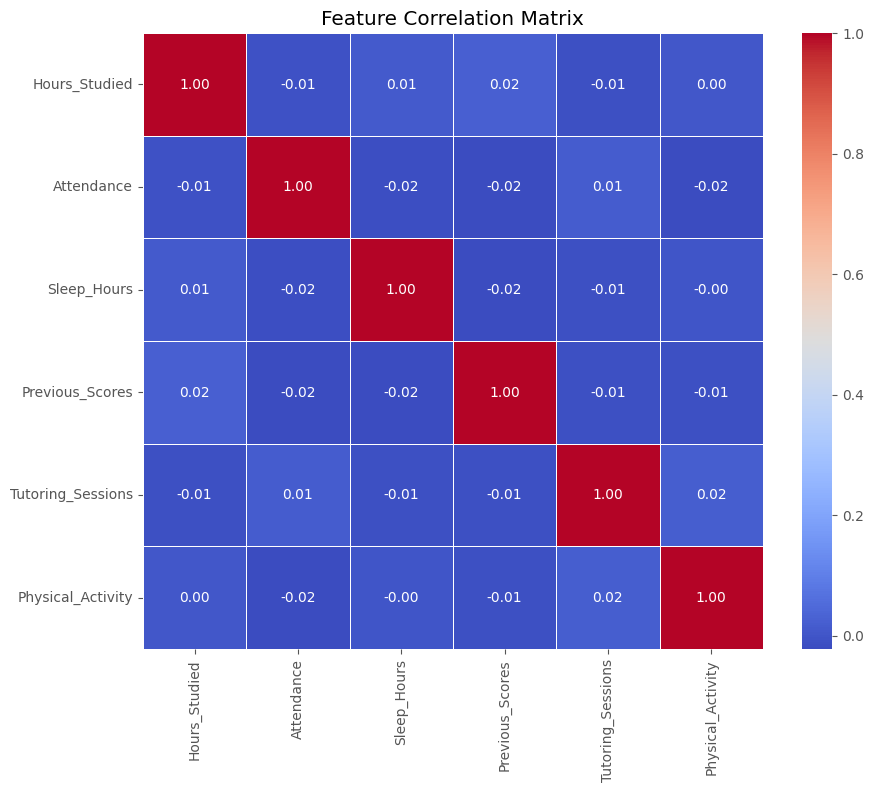

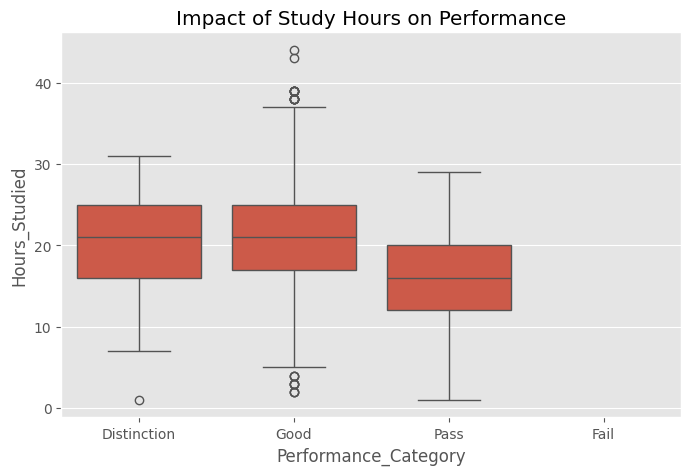

In [3]:
def perform_eda(df):
    """
    Generates summary statistics and visualizations.
    """
    # 1. Summary Statistics
    print("\n--- Numerical Summary ---")
    print(df.describe())
    
    # 2. Target Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Performance_Category', data=df, palette='viridis', order=["Distinction", "Good", "Pass", "Fail"])
    plt.title('Target Distribution: Student Performance')
    plt.show()
    
    # 3. Correlation Matrix (Numerical Features Only)
    plt.figure(figsize=(10, 8))
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.show()
    
    # 4. Boxplot: Hours Studied vs Performance
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Performance_Category', y='Hours_Studied', data=df, order=["Distinction", "Good", "Pass", "Fail"])
    plt.title('Impact of Study Hours on Performance')
    plt.show()

perform_eda(df)

## Feature Engineering

In [4]:
def feature_engineering(X):
    """
    Custom function to create domain-specific features.
    Designed to work within a FunctionTransformer.
    """
    X_new = X.copy()
    
    # Feature 1: Effective Study Score (Interaction)
    # Rationale: Studying a lot matters less if attendance is poor.
    # Check if columns exist to prevent errors
    if 'Hours_Studied' in X_new.columns and 'Attendance' in X_new.columns:
        X_new['Effective_Study'] = X_new['Hours_Studied'] * (X_new['Attendance'] / 100)
        
    # Feature 2: Wellness Index (Aggregation)
    # Rationale: Sleep and Physical activity contribute to cognitive function.
    if 'Sleep_Hours' in X_new.columns and 'Physical_Activity' in X_new.columns:
        X_new['Wellness_Index'] = X_new['Sleep_Hours'] + X_new['Physical_Activity']
        
    return X_new

# Separate Features and Target
X = df.drop('Performance_Category', axis=1)
y = df['Performance_Category']


classes = sorted(y.unique())
reversed_mapping = {cls: len(classes) - 1 - i for i, cls in enumerate(classes)}
print("Reversed Mapping Rules:", reversed_mapping)
y_encoded = y.map(reversed_mapping)

# Encode Target to Integers (Required for XGBoost)
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)
class_names = list(reversed_mapping.keys())
# print(f"Target Mapping: {dict(zip(range(len(class_names)), class_names))}")

# Split: 70% Train, 15% Validation, 15% Test
# First, split into Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.30, stratify=y_encoded, random_state=SEED
)
# Split Temp into Val (15%) and Test (15%) -> 50% of 30% is 15% total
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

print(f"Train Shape: {X_train.shape}, Val Shape: {X_val.shape}, Test Shape: {X_test.shape}")

Reversed Mapping Rules: {'Distinction': 2, 'Good': 1, 'Pass': 0}
Train Shape: (4624, 19), Val Shape: (991, 19), Test Shape: (992, 19)


In [25]:
df

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Performance_Category
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,Good
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,Pass
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,Good
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,Good
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,Good
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,Good
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,Good
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,Good


## Processing Pipeline

In [18]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# 1. Define Preprocessing (StandardScaler is best for Gaussian)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Mean is fine for Gaussian
    ('scaler', StandardScaler())                 # Z-score scaling
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 2. Define the Pipeline with SMOTE
# We use ImbPipeline because it handles resampling correctly (only on train data)
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=2)), # k=2 because you only have 48 Distinction samples
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])

# Now you can run pipeline.fit(X_train, y_train)

In [8]:
# --- 2. Pipeline Definitions ---

# Identify Column Types (Ensure X is defined in your notebook)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Numeric Transformer: Impute -> Handle Outliers -> Scale
numeric_transformer = Pipeline(steps=[
    # Step A: Handle Missing Values (Median is robust to outliers)
    ('imputer', SimpleImputer(strategy='median')),
    
    # Step B: Handle Outliers (New addition)
    # We apply this AFTER imputation so NaNs don't break the quantile calculation
    
    # Step C: Scale Features
    ('scaler', StandardScaler())
])

# Categorical Transformer: Impute -> OneHot
categorical_transformer = Pipeline(steps=[
    # Handle Missing Values for categories (replace with most frequent)
    ('imputer', SimpleImputer(strategy='most_frequent')),
    
    # Encode variables
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Feature Engineering Transformer (Assumes function 'feature_engineering' exists)
feature_eng_transformer = FunctionTransformer(feature_engineering, validate=False)

# --- 3. Full Pipeline Getter ---
def get_pipeline(classifier):
    return Pipeline(steps=[
        # 1. Create new features first
        ('feat_eng', feature_eng_transformer),
        
        # 2. Clean, Cap Outliers, and Scale
        ('preprocessor', preprocessor),
        
        # 3. Model
        ('classifier', classifier)
        ])

In [20]:
# Identify Column Types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# 1. Numeric Transformer: Impute median -> Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical Transformer: Impute freq -> OneHot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Combine into Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Create Feature Engineering Transformer
feature_eng_transformer = FunctionTransformer(feature_engineering, validate=False)

# 5. Full Pipeline Construction (Preprocessing Only)
# Note: We apply feature engineering BEFORE column transformation to ensure new columns are processed
def get_pipeline(classifier):
    return Pipeline(steps=[
        ('feat_eng', feature_eng_transformer),
        # Note: We would need to update column lists dynamically for ColumnTransformer 
        # if Feature Engineering adds columns. 
        # For simplicity in this demo, we assume Feature Engineering happens inside the 
        # Optuna loop or we treat 'preprocessor' as dealing with original columns.
        # *Correction for Robustness*: In production, we usually run FE first, then define 
        # ColumnTransformer on the new dataframe structure. 
        # To keep it simple for this script, we will apply FE logic inside the pipeline 
        # but let the ColumnTransformer handle the output "passthrough" or re-selector.
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

## Hyperparameter Tuning

In [19]:
def objective(trial):
    """
    Optuna objective function to optimize Random Forest and XGBoost.
    """
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'XGBoost'])
    
    if classifier_name == 'RandomForest':
        param = {
            'n_estimators': trial.suggest_int('rf_n_estimators', 50, 300),
            'max_depth': trial.suggest_int('rf_max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 15),
            'class_weight': 'balanced'
        }
        clf = RandomForestClassifier(**param, random_state=SEED, n_jobs=-1)
        
    else: # XGBoost
        param = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 300),
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
            'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0),
            'eval_metric': 'mlogloss'
        }
        clf = XGBClassifier(**param, random_state=SEED, n_jobs=-1)

    # Build Pipeline
    # IMPORTANT: We apply feature engineering to X_train before passing to CV
    # to handle the dynamic column issue mentioned above, 
    # or we ensure the preprocessor handles the output of feature_engineering.
    # Here we simplify:
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # 3-Fold Stratified Cross-Validation on TRAIN set
    # We optimize for 'f1_weighted' due to potential class imbalance
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted')
    return scores.mean()

# Run Optimization
print("Starting Optuna Study...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # Increase n_trials for better results

print(f"Best Classifier: {study.best_params['classifier']}")
print(f"Best F1 Score: {study.best_value:.4f}")

[I 2025-12-03 14:40:32,115] A new study created in memory with name: no-name-50f799ac-dd11-4882-85e9-a0ce02981d37


Starting Optuna Study...


[I 2025-12-03 14:40:34,165] Trial 0 finished with value: 0.9391737634303651 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 154, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.15244830900610248, 'xgb_subsample': 0.6647845438725367, 'xgb_colsample_bytree': 0.6426898143828927}. Best is trial 0 with value: 0.9391737634303651.
[I 2025-12-03 14:40:37,360] Trial 1 finished with value: 0.8882411558445414 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 296, 'rf_max_depth': 26, 'rf_min_samples_split': 4}. Best is trial 0 with value: 0.9391737634303651.
[I 2025-12-03 14:40:38,195] Trial 2 finished with value: 0.8856231533934286 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 62, 'rf_max_depth': 13, 'rf_min_samples_split': 3}. Best is trial 0 with value: 0.9391737634303651.
[I 2025-12-03 14:40:40,388] Trial 3 finished with value: 0.9404452150371739 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 183, 'xgb_max_depth': 9, 'xgb_learning_rat

Best Classifier: XGBoost
Best F1 Score: 0.9553


## Final evaluation & Feature Importance


FINAL EVALUATION: XGBoost
Accuracy: 0.9617
F1 Score (Weighted): 0.9594

Classification Report:

              precision    recall  f1-score   support

 Distinction       0.95      0.90      0.92       218
        Good       0.97      0.99      0.98       769
        Pass       0.00      0.00      0.00         5

    accuracy                           0.96       992
   macro avg       0.64      0.63      0.63       992
weighted avg       0.96      0.96      0.96       992



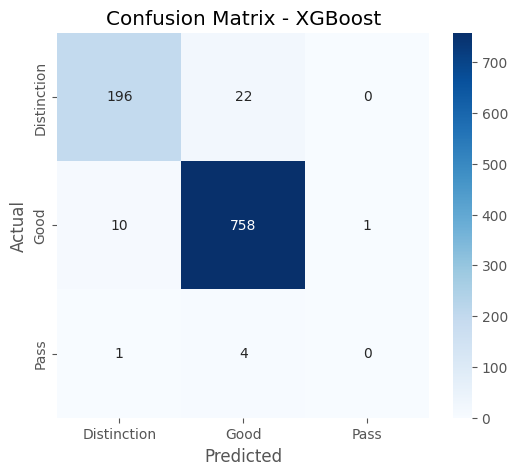

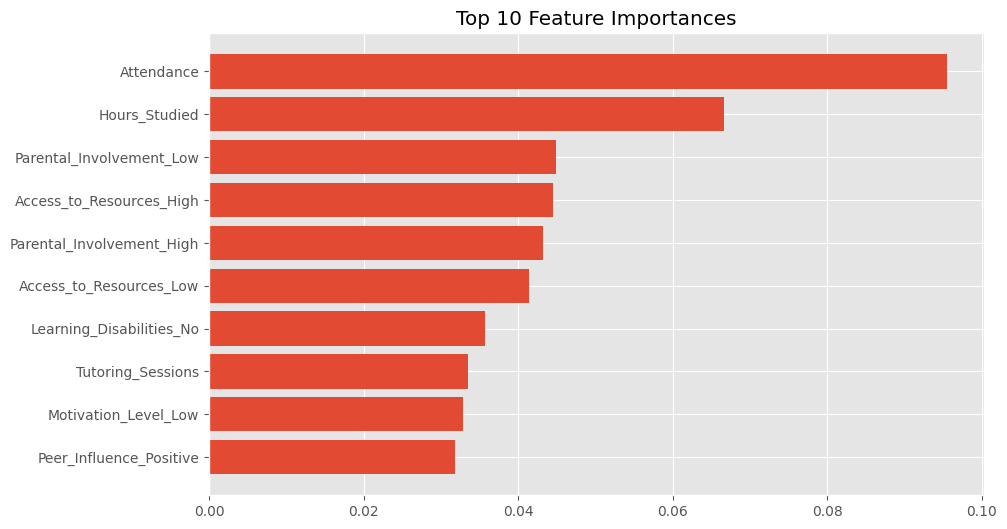

In [20]:
# Extract Best Params
best_params = study.best_params
model_type = best_params.pop('classifier')

# Instantiate Best Model
if model_type == 'RandomForest':
    # Clean keys for RF
    rf_params = {k.replace('rf_', ''): v for k, v in best_params.items()}
    final_clf = RandomForestClassifier(**rf_params, random_state=SEED, class_weight='balanced')
else:
    # Clean keys for XGB
    xgb_params = {k.replace('xgb_', ''): v for k, v in best_params.items()}
    final_clf = XGBClassifier(**xgb_params, random_state=SEED, eval_metric='mlogloss')

# Final Pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_clf)
])

# Train on Train + Validation set (Optional, but often good practice)
X_final_train = pd.concat([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

final_pipeline.fit(X_final_train, y_final_train)

# Predict on Test Set
y_pred = final_pipeline.predict(X_test)

# --- METRICS ---
print("\n" + "="*30)
print(f"FINAL EVALUATION: {model_type}")
print("="*30)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {model_type}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- FEATURE IMPORTANCE ---
# Extracting feature names after OneHotEncoding is tricky but necessary for interpretation
if hasattr(final_clf, 'feature_importances_'):
    # Get transformed feature names
    try:
        # Access the preprocessor step
        prep = final_pipeline.named_steps['preprocessor']
        
        # Numeric names
        num_names = numeric_features
        
        # Categorical names
        cat_names = prep.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
        
        feature_names = np.r_[num_names, cat_names]
        importances = final_clf.feature_importances_
        
        # Plot Top 10
        indices = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(10, 6))
        plt.title("Top 10 Feature Importances")
        plt.barh(range(10), importances[indices], align="center")
        plt.yticks(range(10), feature_names[indices])
        plt.gca().invert_yaxis()
        plt.show()
    except Exception as e:
        print(f"Could not extract feature names directly: {e}")